In [18]:
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from utils import EarthquakeCatalog
from sklearn.neighbors import BallTree

Cross section along a spreading ridge. 

Steps:
* Get shapefile for spreading ridge
* Convert to better reference system (?)
* Upsample at desired point spacing
* get corresponding earthquake catalog
* get k-nearest earthquakes at each point along spreading ridge
* calculate statistics:
  * b-value (b+)
  * a-value
* get spatially averaged strain along the same section
* correlate statistics to strain rate

Subsequent analysis:
* remove trends associated to spreading rate and faulting style 
* clustrered vs. declustered
* record major geological features along the spreading ridge (e.g. iceland, major earthquakes, etc)

Note that an analysis could closely follow the workflow in:

*A unified perspective of seismicity and fault coupling along the San Andreas Fault*

https://www.science.org/doi/full/10.1126/sciadv.abk1167?fbclid=IwAR2HdRzrYRcHJaV3LrciFyn0m-9RpNZ20oOmbagbXI176iIFLSaHxj3LiUk&intcmp=trendmd-adv&adobe_mc=MCMID%3D22100252661862915997832685880766884763%7CMCORGID%3D242B6472541199F70A4C98A6%2540AdobeOrg%7CTS%3D1652659200

In a quick literature review it seems like some of this analysis has already been done:

*Ice melting and earthquake suppression in Greenland*

https://www.sciencedirect.com/science/article/pii/S1873965214000681#bib3


## Shapefile for the north atlantic spreading ridge

In [2]:
plate_boundaries = gpd.read_file("PB2002_boundaries.json")


In [241]:
plate_boundaries.Type.unique()

array(['', 'subduction'], dtype=object)

In [4]:
north_antlantic_plate_boundary = plate_boundaries.loc[plate_boundaries.Name=='NA-EU']
north_antlantic_plate_boundary


,LAYER,Name,Source,PlateA,PlateB,Type,geometry
62,plate boundary,NA-EU,"by Peter Bird, 1999",NA,EU,,"LINESTRING (125.67900 78.13260, 126.45700 77.6..."
63,plate boundary,NA-EU,Mueller et al. [1987],NA,EU,,"LINESTRING (-15.71560 69.54990, -15.42450 69.8..."
64,plate boundary,NA-EU,Mueller et al. [1987],NA,EU,,"LINESTRING (-29.76980 39.39960, -29.60890 39.9..."


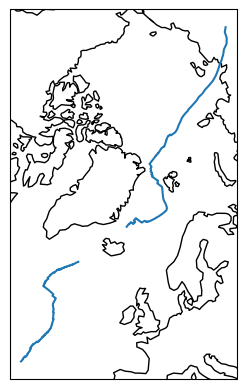

In [5]:
crs = ccrs.NorthPolarStereo()
crs_proj4 = crs.proj4_init
na_pb = north_antlantic_plate_boundary.geometry.to_crs(crs_proj4)

fig, ax = plt.subplots(subplot_kw=dict(projection=crs))
na_pb.plot(ax=ax)
ax.coastlines();


In [6]:
def redistribute_vertices(geom, distance):
    """Redistribute vertices of a geometry with a given point spacing: distance. 

    This is lifted from:
    https://gis.stackexchange.com/questions/367228/using-shapely-interpolate-to-evenly-re-sample-points-on-a-linestring-geodatafram
    """

    if geom.geom_type == 'LineString':
        num_vert = int(round(geom.length / distance))
        if num_vert == 0:
            num_vert = 1
        return LineString(
            [geom.interpolate(float(n) / num_vert, normalized=True)
             for n in range(num_vert + 1)])
    elif geom.geom_type == 'MultiLineString':
        parts = [redistribute_vertices(part, distance)
                 for part in geom]
        return type(geom)([p for p in parts if not p.is_empty])
    else:
        raise ValueError('unhandled geometry %s', (geom.geom_type,))

In [53]:
gdf_line = north_antlantic_plate_boundary.copy()
gdf_line_interpolate = gdf_line.copy()
gdf_line_interpolate.geometry = gdf_line.geometry.apply(redistribute_vertices,distance=1)
gdf_line_interpolate['nverts'] = gdf_line_interpolate.geometry.apply(lambda x: len(x.coords))

In [70]:
gdf_line_interpolate['nverts']

62     25
63    198
64     35
Name: nverts, dtype: int64

In [55]:
print('Total bounds of the selected plate boundary:\n{}'.format(north_antlantic_plate_boundary.total_bounds))

Total bounds of the selected plate boundary:
[-35.4878  39.3996 144.932   86.8049]


## Get earthquakes for the corresponding region

In [56]:
reload_catalog = False
filename = "north_atlantic_catalog.csv"
if reload_catalog is True:
    bounds = north_antlantic_plate_boundary.total_bounds
    catalog = EarthquakeCatalog.get_and_save_catalog(
        filename = filename,
        starttime = "1980-01-01",
        endtime = "2022-01-01",
        latitude_range = bounds[1:4:2],
        longitude_range = bounds[0:3:2],
        minimum_magnitude = 4.5,
    )
else:
    catalog = pd.read_csv(filename)

In [57]:
catalog = EarthquakeCatalog._add_time_column(catalog, "time")

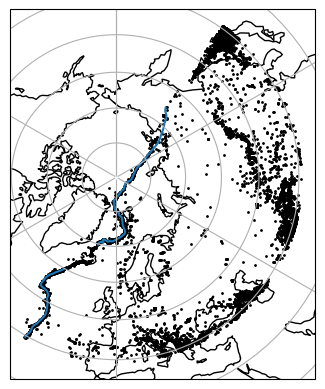

In [71]:
crs = ccrs.NorthPolarStereo()
crs_proj4 = crs.proj4_init
na_pb = gdf_line_interpolate.geometry.to_crs(crs_proj4)

fig, ax = plt.subplots(subplot_kw=dict(projection=crs))
na_pb.plot(ax=ax)
ax.coastlines()
ax.gridlines()
ax.scatter(x=catalog.lon.to_numpy(), y=catalog.lat.to_numpy(), transform=ccrs.PlateCarree(), color='k', s=1);

## distance search

In [178]:
EARTH_RADIUS = 6371 # km 
def radius_search(points,queries,radius)->list[list]:
    """Searches for points within a radius of a query lat lon point and returns a list of corresponding indices."""
    tree = BallTree(np.deg2rad(points), metric='haversine')
    return tree.query_radius(np.deg2rad(queries),r=radius/EARTH_RADIUS,return_distance=False)

def k_nearest_search(points,queries,k):
    """Searches for k nearest points to a query lat lon point and returns a list of corresponding indices."""
    tree = BallTree(np.deg2rad(points), metric='haversine')
    return tree.query(np.deg2rad(queries),k=k)[1] 


## Statistics

In [ ]:
def get_bvalue(M,Mc):
    """Returns the b-value for a given set of magnitudes M."""
    b = 1/np.log(10)*np.mean(M-Mc)
    return b

def get_bpositive(M,Mc):
    """Returns the b-value for a given set of magnitudes M using b positive. 
    
    Note that this assumes that magntidudes are sorted in increasing temporal order."""
    b = get_bvalue(np.diff(M),Mc)
    return b

# TODO: Clustered fraction

# TODO: bootstrapped statistics
def get_bootstrapped(f, kwarg, n=1000):
    """Returns a list of n bootstrapped values of f using the kwarg as input."""
    raise NotImplementedError

## Along strike variations

In [264]:
boundary = gdf_line_interpolate.iloc[1]
queries = np.array([boundary.geometry.coords.xy[1], boundary.geometry.coords.xy[0]]).T
points = np.array([catalog.lat.to_numpy(),catalog.lon.to_numpy()]).T

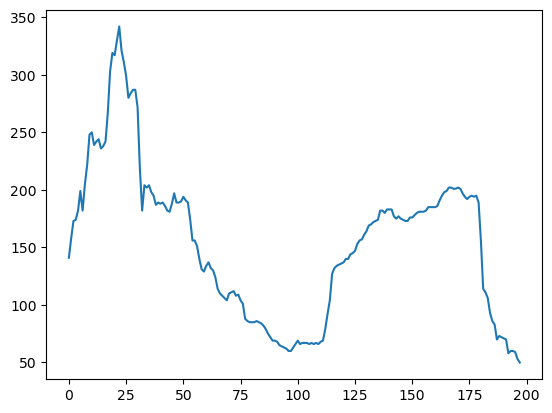

In [265]:
indices = radius_search(points,queries,300)
rate = [len(i) for i in indices]

fig, ax = plt.subplots()
ax.plot(rate)

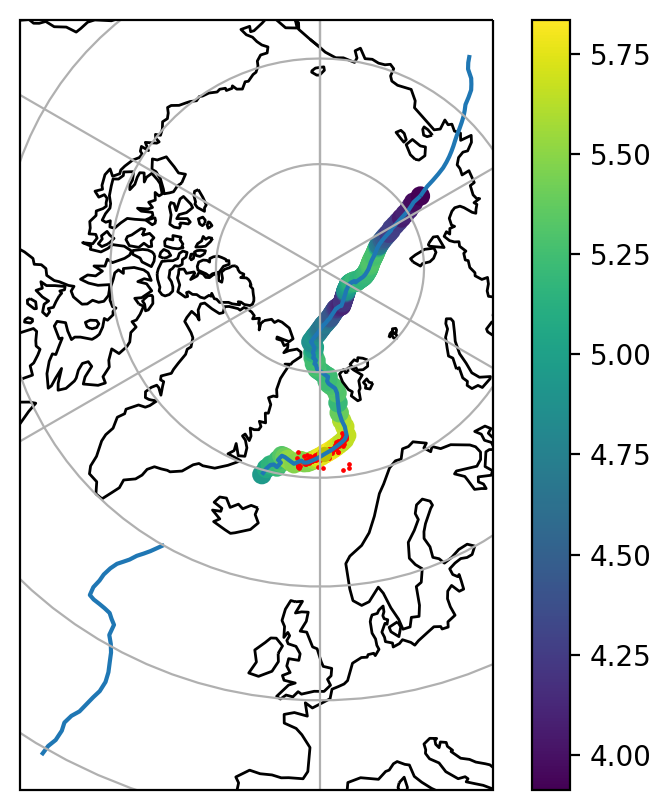

In [266]:
crs = ccrs.NorthPolarStereo()
crs_proj4 = crs.proj4_init
na_pb = gdf_line_interpolate.geometry.to_crs(crs_proj4)

fig, ax = plt.subplots(subplot_kw=dict(projection=crs),figsize=(5,5),dpi=200)
na_pb.plot(ax=ax)
bdr = ax.scatter(queries[:,1],queries[:,0],c=np.log(rate), transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
# ax.scatter(x=catalog.lon.to_numpy(), y=catalog.lat.to_numpy(), transform=ccrs.PlateCarree(), color='k', s=1);
plt.colorbar(bdr)
i = 20
ax.scatter(points[indices[i],1], points[indices[i],0], s=0.5,c='r', transform=ccrs.PlateCarree())
ax.scatter(queries[i,1],queries[i,0],s=20,c='y', transform=ccrs.PlateCarree())

## Variations in time and space:

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_1560/3608475137.py:22: RuntimeWarning: divide by zero encountered in log
  rate = np.log(np.array(rate).T)


Text(0, 0.5, 'Distance along plate boundary')

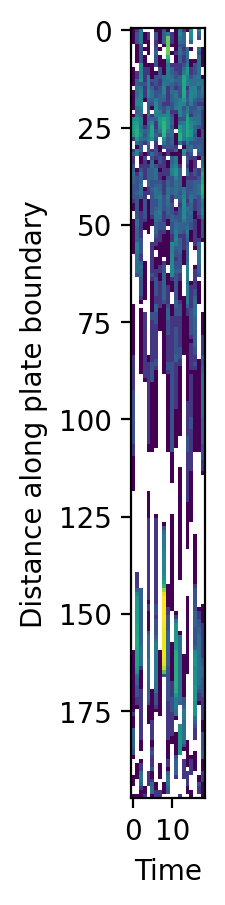

In [269]:
number_of_periods = 20 # year
delta_x = 3 # km
window_size = 100 # km

rate = []
queries = np.array([boundary.geometry.coords.xy[1], boundary.geometry.coords.xy[0]]).T

catalog.time.sort_values(ignore_index=True)

date_range = pd.date_range(
    catalog.time.min(),
    catalog.time.max(),
    periods=number_of_periods
)

for t1,t2 in zip(date_range[:-1],date_range[1:]):
    sub_catalog = catalog[(catalog.time < t2) &  (catalog.time > t1)]
    points = np.array([sub_catalog.lat.to_numpy(),sub_catalog.lon.to_numpy()]).T
    indices = radius_search(points,queries,window_size)
    rate.append([len(i) for i in indices])

rate = np.log(np.array(rate).T)

fig, ax = plt.subplots(figsize=(5,5),dpi=200)
ax.imshow(rate)
ax.set_xlabel("Time")
ax.set_ylabel("Distance along plate boundary")


Timestamp('1980-01-03 15:17:43.110000')

In [254]:
rate

array([], dtype=float64)